<a href="https://colab.research.google.com/github/Kevvvvvvin/zh-cn-NMT/blob/master/zh_en_NMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [56]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # 例如： "he is a boy." => "he is a boy ."
    # 参考：https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub('([.,!?()])', r' \1 ', w)
    w = re.sub(r'[" "]+', " ", w)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # 给句子加上开始和结束标记
    # 以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w

def preprocess_sentence_zh(w):
    
    all_punc= "、【 】 “”：；（）《》‘’{}⑦()、%^>℃：.”“^-——=&#@￥"
    w = u" ".join(jieba.cut(w,cut_all=True))
    w2=[]
    for i in w:
        w2.append(i)
        if i in all_punc:
            w2.remove(i)
    w2 = ''.join(w2)
    w2 = u" ".join(jieba.cut(w2,cut_all=True))
    w2 = '<start> ' + w + ' <end>'
    return w2



In [3]:
en_sentence = u"May I borrow this book?"
zh_sentence = u"我可以借你的书吗？"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence_zh(zh_sentence))

Building prefix dict from the default dictionary ...


<start> may i borrow this book ? <end>


Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.989 seconds.
Prefix dict has been built successfully.


<start> 我 可以 借 你 的 书 吗 ？ <end>


In [6]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    s = [[w for w in l.split('\t')] for l in lines[:num_examples]]
    word_pairs = [[preprocess_sentence(w[0]),preprocess_sentence_zh(w[1])] for w in s]  
    print(zip(*word_pairs))
    return zip(*word_pairs)

In [7]:
en, zh = create_dataset('cmn.txt', None)
print(en[-1])
print(zh[-1])

<start> if a person has not had a chance to acquire his target language by the time he s an adult , he s unlikely to be able to reach native speaker level in that language . <end>
<start> 如果 一 個 人 在 成人 前 沒 有 機 會 習 得 目 標 語 言 ， 他 對 該 語 言 的 認 識 達 到 母 語 者 程度 的 機 會 是 相 當 小 的 。 <end>


In [8]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [10]:
def load_dataset(path, num_examples=None):
    # 创建清理过的输入输出对
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [11]:
# 尝试实验不同大小的数据集
num_examples = 10000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset('cmn.txt', num_examples)

# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [12]:
# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

8000 8000 2000 2000


In [13]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [14]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
6 ----> 你
14 ----> 們
45 ----> 得
76 ----> 走
5 ----> 了
3 ----> 。
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> you
72 ----> need
9 ----> to
35 ----> go
3 ----> .
2 ----> <end>


In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 18]), TensorShape([64, 13]))

In [17]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 样本输入
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 18, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # 隐藏层的形状 == （批大小，隐藏层大小）
    # hidden_with_time_axis 的形状 == （批大小，1，隐藏层大小）
    # 这样做是为了执行加法以计算分数  
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # 分数的形状 == （批大小，最大长度，1）
    # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
    # 在应用 self.V 之前，张量的形状是（批大小，最大长度，单位）
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # 注意力权重 （attention_weights） 的形状 == （批大小，最大长度，1）
    attention_weights = tf.nn.softmax(score, axis=1)

    # 上下文向量 （context_vector） 求和之后的形状 == （批大小，隐藏层大小）
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [20]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 18, 1)


In [21]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # 用于注意力
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # 编码器输出 （enc_output） 的形状 == （批大小，最大长度，隐藏层大小）
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x 在通过嵌入层后的形状 == （批大小，1，嵌入维度）
    x = self.embedding(x)

    # x 在拼接 （concatenation） 后的形状 == （批大小，1，嵌入维度 + 隐藏层大小）
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 将合并后的向量传送到 GRU
    output, state = self.gru(x)

    # 输出的形状 == （批大小 * 1，隐藏层大小）
    output = tf.reshape(output, (-1, output.shape[2]))

    # 输出的形状 == （批大小，vocab）
    x = self.fc(output)

    return x, state, attention_weights

In [22]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 3348)


In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [25]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 教师强制 - 将目标词作为下一个输入
    for t in range(1, targ.shape[1]):
      # 将编码器输出 （enc_output） 传送至解码器
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 使用教师强制
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [26]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # 每 2 个周期（epoch），保存（检查点）一次模型
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.3221
Epoch 1 Batch 100 Loss 2.2094
Epoch 1 Loss 2.4897
Time taken for 1 epoch 551.1045336723328 sec

Epoch 2 Batch 0 Loss 2.1100
Epoch 2 Batch 100 Loss 1.8320
Epoch 2 Loss 1.9157
Time taken for 1 epoch 525.9320185184479 sec

Epoch 3 Batch 0 Loss 1.7396
Epoch 3 Batch 100 Loss 1.6935
Epoch 3 Loss 1.6901
Time taken for 1 epoch 534.1234426498413 sec

Epoch 4 Batch 0 Loss 1.7066
Epoch 4 Batch 100 Loss 1.4734
Epoch 4 Loss 1.4738
Time taken for 1 epoch 535.869875907898 sec

Epoch 5 Batch 0 Loss 1.3197
Epoch 5 Batch 100 Loss 1.2496
Epoch 5 Loss 1.2614
Time taken for 1 epoch 536.9471361637115 sec

Epoch 6 Batch 0 Loss 1.0935
Epoch 6 Batch 100 Loss 1.2003
Epoch 6 Loss 1.0647
Time taken for 1 epoch 543.1304533481598 sec

Epoch 7 Batch 0 Loss 0.8065
Epoch 7 Batch 100 Loss 0.8200
Epoch 7 Loss 0.8843
Time taken for 1 epoch 536.8353803157806 sec

Epoch 8 Batch 0 Loss 0.7153
Epoch 8 Batch 100 Loss 0.8107
Epoch 8 Loss 0.7179
Time taken for 1 epoch 527.1103324890137 sec

Epoch 9 B

In [35]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence_zh(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [70]:
#coding:utf-8
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


In [68]:
# 注意力权重制图函数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [37]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [44]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> 这 是 真的 吗 <end>
Predicted translation: it s it true ? <end> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36825 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26159 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21527 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 36825 missing from current font.
  font.set_

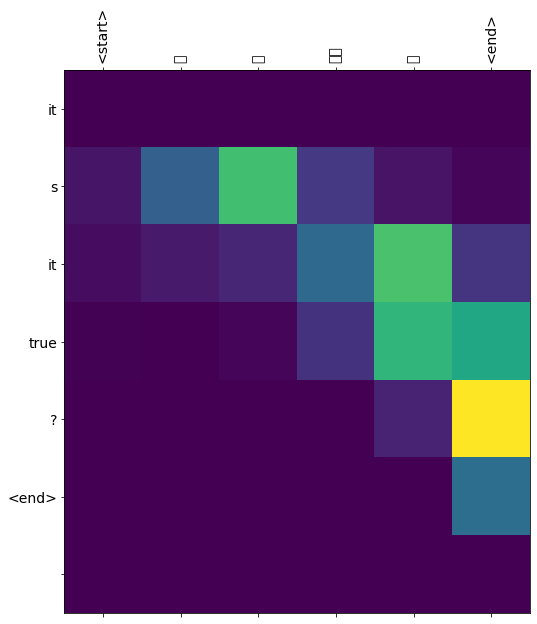

In [71]:
translate(u"这是真的吗")